In [1]:
# https://datahacker.rs/006-gans-how-to-develop-a-1d-gan-from-scratch/

In [2]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn.functional as F

import random
import math

# 3 Independent variables

In [3]:
def temperature_0(n_samples):
    
    return torch.rand(n_samples)

In [4]:
def pressure_0(n_samples):
    
    return torch.rand(n_samples)

In [5]:
def failure(n_samples):
    
    return torch.randint(0, 1, (n_samples, ))

In [9]:
def generate_ndim_3_free_samples(n, n_dim):
    
    temp = torch.rand(n).view(n, 1)
    press = torch.rand(n).view(n, 1)
    fail = torch.randint(0, 2, (n, 1))
    y_data = torch.ones((n,1))
    
    signals = [fail, temp, press]
    
    temp_dim = math.floor((n_dim - 3) / 2)
        
    for dim in range(temp_dim):
        
        alpha = torch.rand(1)
        
        temp_k = alpha*temp
        
        signals.append(temp_k)
        
    press_dim = n_dim - temp_dim - 3
        
    for dim in range(press_dim):
        
        beta = torch.rand(1)
        
        press_k = beta*press
        
        signals.append(press_k)
    
    return torch.hstack(signals), y_data

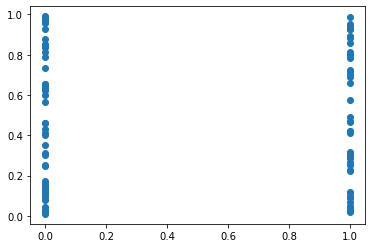

In [10]:
test_generated_data = generate_ndim_3_free_samples(100, 15)

plt.scatter(test_generated_data[0][:,0].numpy(), test_generated_data[0][:,1].numpy())

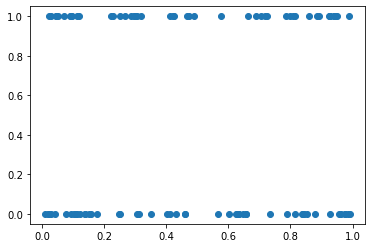

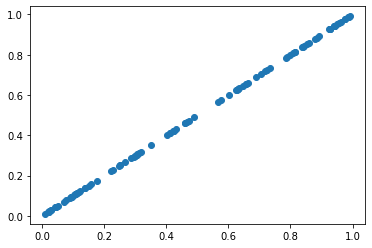

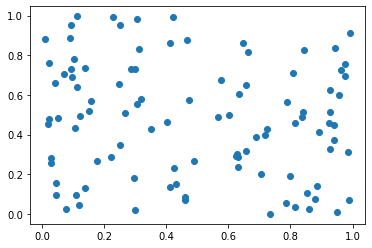

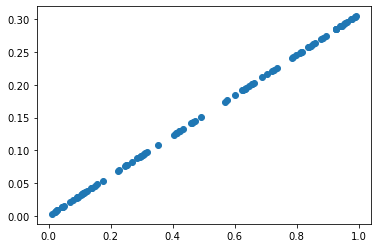

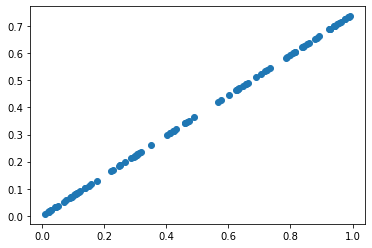

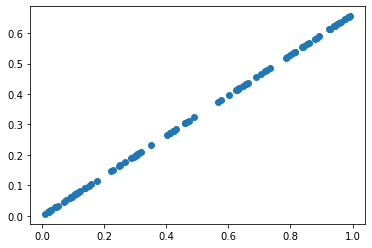

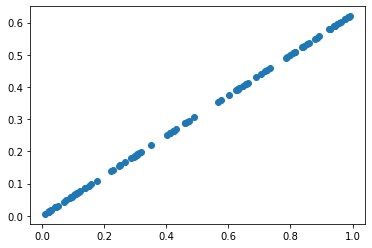

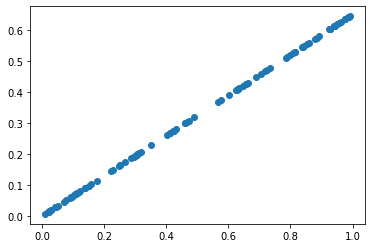

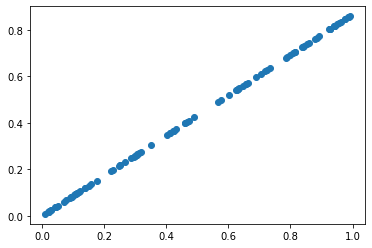

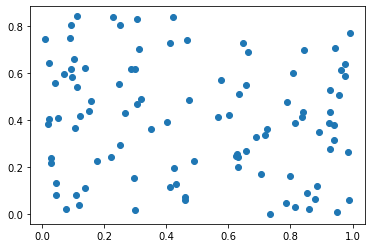

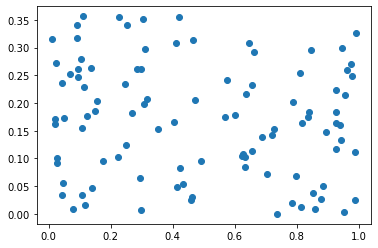

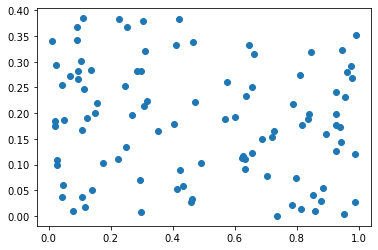

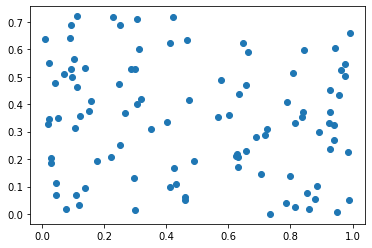

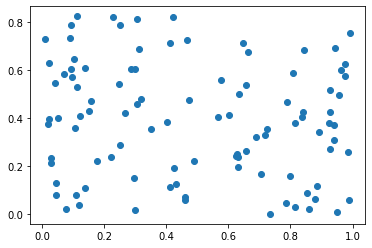

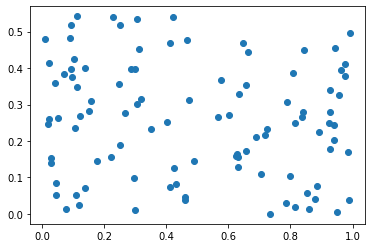

In [11]:
# Verifying co-linearity among temperatures
for k in range(test_generated_data[0].shape[1]):
    plt.scatter(test_generated_data[0][:,1].numpy(), test_generated_data[0][:,k].numpy())
    plt.show()

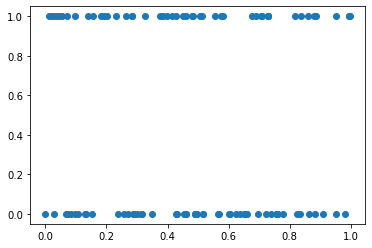

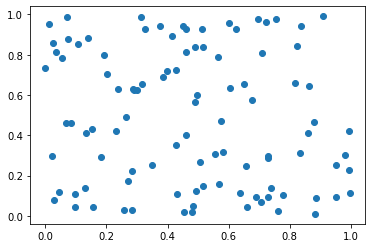

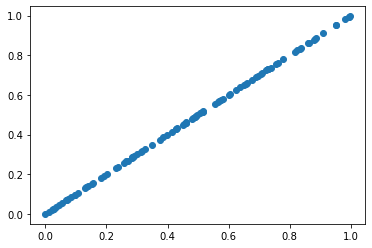

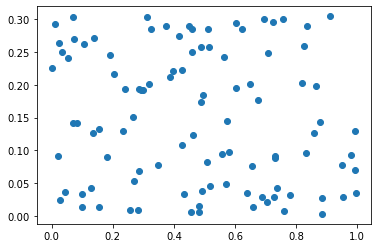

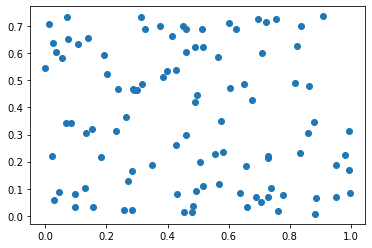

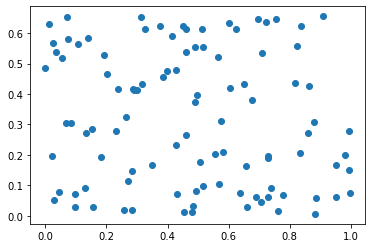

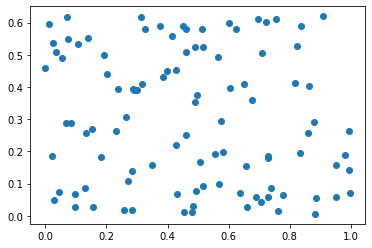

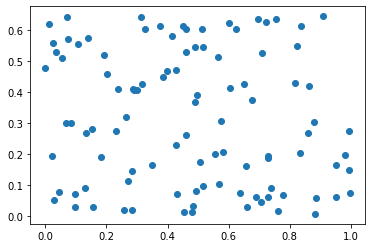

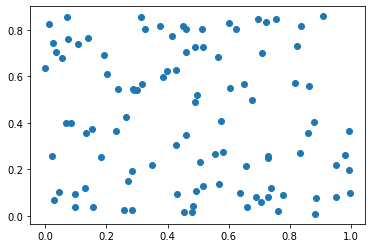

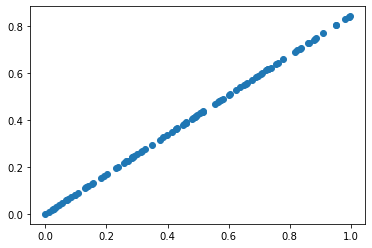

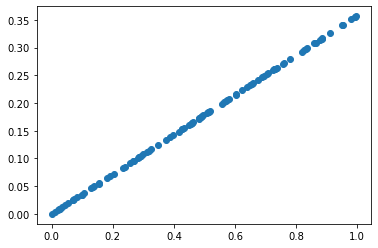

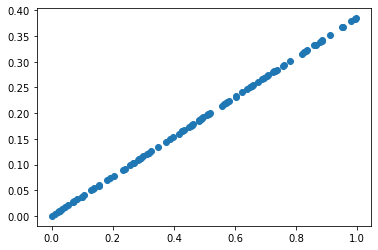

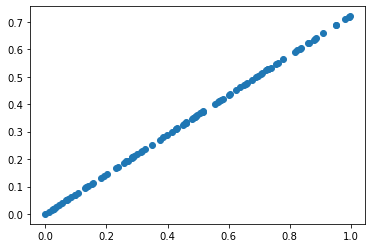

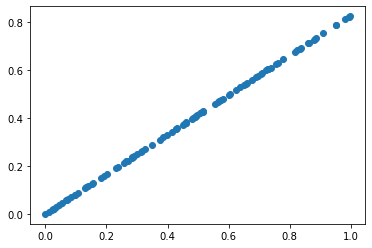

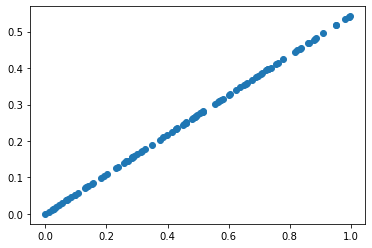

In [12]:
# Verifying co-linearity among pressures
for k in range(test_generated_data[0].shape[1]):
    plt.scatter(test_generated_data[0][:,2].numpy(), test_generated_data[0][:,k].numpy())
    plt.show()

In [13]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.fc1 = nn.Linear(4, 25)
#         self.fc2 = nn.Linear(25,1)

#     def forward(self,x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         x = torch.sigmoid(x)
#         return x

In [14]:
class Discriminator_ndim(nn.Module):
    def __init__(self, ndim, hidden):
        super(Discriminator_ndim, self).__init__()
        self.fc1 = nn.Linear(ndim, hidden)
#         self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden,1)

    def forward(self,x):
        x = self.fc1(x)
        x = F.leaky_relu(x)
#         x = self.fc2(x)
#         x = F.leaky_relu(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [15]:
discriminator = Discriminator_ndim(15, 25)
# test a discriminator with a simple input - sanity check
x_data_test = torch.rand(15)
discriminator(x_data_test)

tensor([0.5409], grad_fn=<SigmoidBackward0>)

In [16]:
# def generate_dummy_fake_data(n):
#     x1 = torch.rand(n) * 2 * torch.pi
#     x2 = torch.rand(n) * 2 * torch.pi
#     x3 = torch.rand(n) * 2 * torch.pi
#     x4 = torch.rand(n) * 2 * torch.pi
#     x1 = x1.view(n,1)
#     x2 = x2.view(n,1)
#     x3 = x3.view(n,1)
#     x4 = x4.view(n,1)
#     y_fake = torch.zeros((n,1))
#     return torch.hstack((x1, x2, x3, x4)), y_fake

In [17]:
def generate_dummy_fake_ndim(n, ndim):
    
    signals = []
    y_fake = torch.zeros((n,1))
    
    for dim in range(ndim):
        
        x_dim = torch.rand(n)
        x_dim = x_dim.view(n, 1)
        signals.append(x_dim)
    
    return torch.hstack(signals), y_fake

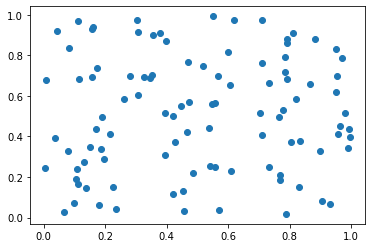

In [18]:
x_fake,y_fake = generate_dummy_fake_ndim(100, 5)
plt.scatter(x_fake[:, 0].numpy(),x_fake[:, 1].numpy())

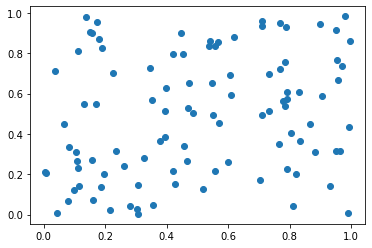

In [19]:
plt.scatter(x_fake[:, 0].numpy(),x_fake[:, 2].numpy())

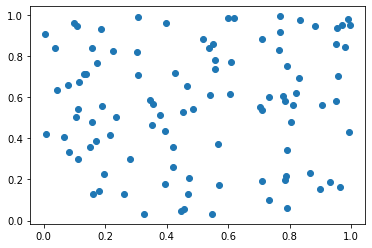

In [20]:
plt.scatter(x_fake[:, 0].numpy(),x_fake[:, 3].numpy())

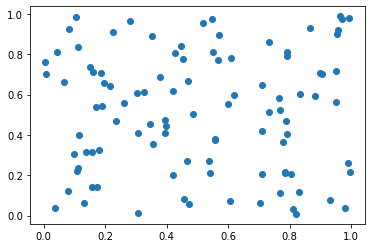

In [21]:
plt.scatter(x_fake[:, 0].numpy(),x_fake[:, 4].numpy())

In [22]:
discriminator = Discriminator_ndim(15, 10)
optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.001) 
criterion = torch.nn.BCELoss()

In [23]:
epochs = 1000
n = 100
n_dim = 15
hidden = 10

discriminator = Discriminator_ndim(n_dim, hidden)
optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.001) 
criterion = torch.nn.BCELoss()

x_data, y_data = generate_ndim_3_free_samples(n, n_dim)
x_fake, y_fake = generate_dummy_fake_ndim(n, n_dim)

x_all = torch.vstack((x_data, x_fake))
y_all = torch.vstack((y_data, y_fake))
all_loss = []
for i in range(epochs):
    y_hat = discriminator(x_all)
    loss = criterion(y_hat, y_all)
    all_loss.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

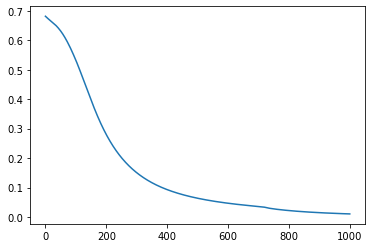

In [24]:
plt.plot(all_loss)

In [25]:
# # define a Generator Model

# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()

#         self.fc1 = nn.Linear(5,15)
#         self.fc2 = nn.Linear(15, 4)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         # note that here we are not adding any activation functions
#         # since we assume the linear output as the values can be negative as well
#         # in other words this activation function here is just an "identity function" f(x)=x
#         return x

In [26]:
class Generator_ndim(nn.Module):
    def __init__(self, n_dim, hidden):
        super(Generator_ndim, self).__init__()

        self.fc1 = nn.Linear(5, hidden)
#         self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, n_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
#         x = self.fc2(x)
#         x = F.relu(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        # note that here we are not adding any activation functions
        # since we assume the linear output as the values can be negative as well
        # in other words this activation function here is just an "identity function" f(x)=x
        return x

In [27]:
generator = Generator_ndim(6, 6)
test_generator = generator(torch.rand(5))
print(test_generator)

tensor([0.4921, 0.4575, 0.5122, 0.5048, 0.5913, 0.5471],
       grad_fn=<SigmoidBackward0>)


In [28]:
def generate_latent_points(n, latent_dim=5):
    # here we will assume that in the z-space 
    # or latent space we have 5 dimensional random vector 
    z = torch.rand(n*latent_dim)
    return z.view((n,latent_dim))

a = generate_latent_points(10)
print(a)

tensor([[0.4872, 0.7151, 0.4313, 0.4638, 0.0424],
        [0.0741, 0.9445, 0.4927, 0.1942, 0.8841],
        [0.3999, 0.9317, 0.1060, 0.4941, 0.6941],
        [0.9644, 0.1823, 0.5556, 0.1475, 0.7219],
        [0.8297, 0.2717, 0.6016, 0.0397, 0.3128],
        [0.5469, 0.9695, 0.3636, 0.9805, 0.5658],
        [0.8686, 0.9395, 0.1272, 0.9395, 0.3145],
        [0.3683, 0.1908, 0.5804, 0.7584, 0.9855],
        [0.5440, 0.9263, 0.9457, 0.4007, 0.1093],
        [0.3433, 0.3013, 0.3449, 0.3552, 0.5564]])


In [29]:
def generate_fake_samples(generator, n, latent_dim=5):
    z = generate_latent_points(n)
    fake_data = generator(z)
    return fake_data 

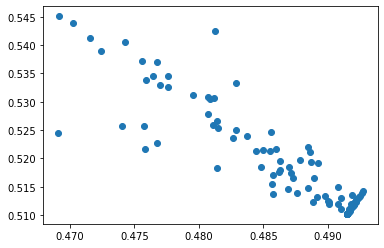

In [30]:
fake_data_test = generate_fake_samples(generator, 100)
plt.scatter(fake_data_test[:,0].detach().numpy(), fake_data_test[:,2].detach().numpy())

In [47]:
training_steps = 200_000    
n_dim = 15
hidden_g = 35
hidden_d = 35

# Models
generator =     Generator_ndim(n_dim, hidden_g)
discriminator = Discriminator_ndim(n_dim, hidden_d)

# Optimizers
generator_optimizer     = torch.optim.Adam(generator.parameters(),     lr=0.001)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

# loss
loss = nn.BCELoss()
# loss = nn.MSELoss()

discriminator_losses = []
generator_losses = []

N = 128

for i in tqdm(range(training_steps)):
    # zero the gradients on each iteration
    generator_optimizer.zero_grad()
#    if i%5000 ==0:
#        print(f"{i} \n")

    # Create a fake data with a generator
    fake_data = generate_fake_samples(generator, N)

    # here we define the INVERSE labels for fake data
    fake_data_label = torch.ones(N,1)

    # Generate examples of real data
    real_data, real_data_label = generate_ndim_3_free_samples(N, n_dim)
    
    # Train the generator
    # We invert the labels here and don't train the discriminator because we want the generator
    # to make things the discriminator classifies as true.
    generator_discriminator_out = discriminator(fake_data)
    generator_loss = loss(generator_discriminator_out, fake_data_label)
    generator_loss.backward()
    generator_optimizer.step()
    generator_losses.append(generator_loss.item())


    # Train the discriminator on the true/generated data
    discriminator_optimizer.zero_grad()
    true_discriminator_out = discriminator(real_data)
    true_discriminator_loss = loss(true_discriminator_out, real_data_label)

    # here a fake_data is passed with a gradient turned off
    # see our post about <a href="https://datahacker.rs/004-computational-graph-and-autograd-with-pytorch/#Automatic-differentiation-module-in-PyTorch---Autograd">AUTOGRAD</a>
    generator_discriminator_out = discriminator(fake_data.detach())
    generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros(N,1))
    discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
    discriminator_loss.backward()
    discriminator_optimizer.step()
    discriminator_losses.append(discriminator_loss.item())
    
#     mean_loss = (generator_loss.item() + discriminator_loss.item()) / 2
    
    if (i%1000) == 0:
        print(i)
#         print(mean_loss)
        print(f'Generator loss: {generator_loss.item()}')
        print(f'Discriminator loss: {discriminator_loss.item()}')
        print('---')
    
    # early stopping
    if discriminator_loss.item() < 0.3 and generator_loss.item() < 0.4 and i > 1_000 and i > 20_000:
        print(f'Early stop!! Generator loss: {generator_loss.item()} / Discriminator loss: {discriminator_loss.item()}')
        break

  0%|                                     | 194/200000 [00:00<03:23, 979.84it/s]

0
Generator loss: 0.8334505558013916
Discriminator loss: 0.6733171939849854
---


  1%|▏                                   | 1177/200000 [00:01<03:19, 996.45it/s]

1000
Generator loss: 1.0341362953186035
Discriminator loss: 0.5069659948348999
---


  1%|▎                                  | 2113/200000 [00:02<03:08, 1049.74it/s]

2000
Generator loss: 1.4848859310150146
Discriminator loss: 0.43882355093955994
---


  2%|▌                                  | 3216/200000 [00:03<02:58, 1101.05it/s]

3000
Generator loss: 0.9021223783493042
Discriminator loss: 1.0857608318328857
---


  2%|▋                                  | 4115/200000 [00:03<02:55, 1115.53it/s]

4000
Generator loss: 2.086683988571167
Discriminator loss: 0.11376705765724182
---


  3%|▉                                  | 5134/200000 [00:04<02:53, 1124.49it/s]

5000
Generator loss: 1.8359699249267578
Discriminator loss: 0.14315755665302277
---


  3%|█                                  | 6154/200000 [00:05<02:52, 1125.61it/s]

6000
Generator loss: 1.628359079360962
Discriminator loss: 0.49684616923332214
---


  4%|█▎                                 | 7171/200000 [00:06<02:55, 1099.83it/s]

7000
Generator loss: 1.3375777006149292
Discriminator loss: 0.33664393424987793
---


  4%|█▍                                 | 8183/200000 [00:07<02:52, 1114.40it/s]

8000
Generator loss: 1.470729947090149
Discriminator loss: 1.1026955842971802
---


  5%|█▌                                 | 9193/200000 [00:08<02:51, 1109.57it/s]

9000
Generator loss: 1.5339479446411133
Discriminator loss: 0.2518410384654999
---


  5%|█▋                                | 10204/200000 [00:09<02:49, 1117.52it/s]

10000
Generator loss: 1.3806383609771729
Discriminator loss: 0.3288279175758362
---


  6%|█▉                                | 11212/200000 [00:10<02:50, 1105.09it/s]

11000
Generator loss: 0.776534914970398
Discriminator loss: 0.7213478088378906
---


  6%|██                                | 12218/200000 [00:11<02:54, 1079.17it/s]

12000
Generator loss: 0.7464374303817749
Discriminator loss: 0.5781307816505432
---


  7%|██▏                               | 13221/200000 [00:12<02:50, 1094.02it/s]

13000
Generator loss: 2.0581202507019043
Discriminator loss: 0.13567161560058594
---


  7%|██▍                               | 14116/200000 [00:12<02:47, 1110.04it/s]

14000
Generator loss: 1.086952567100525
Discriminator loss: 0.5365691184997559
---


  8%|██▌                               | 15123/200000 [00:13<02:46, 1109.88it/s]

15000
Generator loss: 1.6366420984268188
Discriminator loss: 0.36854109168052673
---


  8%|██▋                               | 16131/200000 [00:14<02:45, 1113.55it/s]

16000
Generator loss: 1.3670727014541626
Discriminator loss: 0.5553106069564819
---


  9%|██▉                               | 17141/200000 [00:15<02:44, 1113.25it/s]

17000
Generator loss: 1.0655126571655273
Discriminator loss: 0.49527353048324585
---


  9%|███                               | 18152/200000 [00:16<02:42, 1116.44it/s]

18000
Generator loss: 1.5130131244659424
Discriminator loss: 0.39693933725357056
---


 10%|███▎                              | 19168/200000 [00:17<02:41, 1119.84it/s]

19000
Generator loss: 1.8450520038604736
Discriminator loss: 0.17758169770240784
---


 10%|███▍                              | 20182/200000 [00:18<02:41, 1115.95it/s]

20000
Generator loss: 1.4181064367294312
Discriminator loss: 1.0203988552093506
---


 11%|███▌                              | 21193/200000 [00:19<02:41, 1107.81it/s]

21000
Generator loss: 1.0500431060791016
Discriminator loss: 0.3111352026462555
---


 11%|███▊                              | 22204/200000 [00:20<02:39, 1116.73it/s]

22000
Generator loss: 1.6063120365142822
Discriminator loss: 0.2875606417655945
---


 12%|███▉                              | 23220/200000 [00:21<02:37, 1122.80it/s]

23000
Generator loss: 2.019122838973999
Discriminator loss: 0.7674086093902588
---


 12%|████                              | 24123/200000 [00:21<02:37, 1118.02it/s]

24000
Generator loss: 1.498833179473877
Discriminator loss: 0.32941943407058716
---


 13%|████▎                             | 25139/200000 [00:22<02:35, 1122.61it/s]

25000
Generator loss: 1.5212873220443726
Discriminator loss: 0.3534964919090271
---


 13%|████▍                             | 26151/200000 [00:23<02:36, 1110.92it/s]

26000
Generator loss: 2.2935595512390137
Discriminator loss: 0.19539636373519897
---


 14%|████▌                             | 27166/200000 [00:24<02:34, 1118.21it/s]

27000
Generator loss: 1.4957225322723389
Discriminator loss: 0.42920657992362976
---


 14%|████▊                             | 28181/200000 [00:25<02:33, 1117.97it/s]

28000
Generator loss: 0.882222592830658
Discriminator loss: 1.5188279151916504
---


 15%|████▉                             | 29195/200000 [00:26<02:33, 1113.68it/s]

29000
Generator loss: 1.207320213317871
Discriminator loss: 0.5964541435241699
---


 15%|█████▏                            | 30208/200000 [00:27<02:31, 1120.64it/s]

30000
Generator loss: 1.7446677684783936
Discriminator loss: 0.750669538974762
---


 16%|█████▎                            | 31221/200000 [00:28<02:30, 1119.02it/s]

31000
Generator loss: 1.619354486465454
Discriminator loss: 0.3045947253704071
---


 16%|█████▍                            | 32116/200000 [00:28<02:31, 1109.11it/s]

32000
Generator loss: 1.6902978420257568
Discriminator loss: 0.504302978515625
---


 17%|█████▋                            | 33126/200000 [00:29<02:30, 1111.84it/s]

33000
Generator loss: 1.4564390182495117
Discriminator loss: 0.5505072474479675
---


 17%|█████▊                            | 34135/200000 [00:30<02:29, 1112.99it/s]

34000
Generator loss: 1.4845304489135742
Discriminator loss: 0.28376755118370056
---


 18%|█████▉                            | 35146/200000 [00:31<02:27, 1114.47it/s]

35000
Generator loss: 1.8376048803329468
Discriminator loss: 0.28323984146118164
---


 18%|██████▏                           | 36160/200000 [00:32<02:26, 1118.47it/s]

36000
Generator loss: 1.715252161026001
Discriminator loss: 0.3098657429218292
---


 19%|██████▎                           | 37174/200000 [00:33<02:26, 1113.73it/s]

37000
Generator loss: 2.190755844116211
Discriminator loss: 0.1778457760810852
---


 19%|██████▍                           | 38191/200000 [00:34<02:24, 1120.61it/s]

38000
Generator loss: 1.8066744804382324
Discriminator loss: 0.15194150805473328
---


 20%|██████▋                           | 39206/200000 [00:35<02:24, 1115.22it/s]

39000
Generator loss: 1.6233450174331665
Discriminator loss: 0.4490028917789459
---


 20%|██████▊                           | 40219/200000 [00:36<02:22, 1118.40it/s]

40000
Generator loss: 1.4017221927642822
Discriminator loss: 0.3674522936344147
---


 21%|██████▉                           | 41121/200000 [00:37<02:21, 1122.11it/s]

41000
Generator loss: 1.545485019683838
Discriminator loss: 0.17877811193466187
---


 21%|███████▏                          | 42138/200000 [00:37<02:20, 1120.27it/s]

42000
Generator loss: 2.64945650100708
Discriminator loss: 0.10940198600292206
---


 22%|███████▎                          | 43151/200000 [00:38<02:20, 1114.75it/s]

43000
Generator loss: 1.346178650856018
Discriminator loss: 0.7018513679504395
---


 22%|███████▌                          | 44159/200000 [00:39<02:21, 1101.54it/s]

44000
Generator loss: 1.5947335958480835
Discriminator loss: 0.2531285881996155
---


 23%|███████▋                          | 45168/200000 [00:40<02:20, 1102.88it/s]

45000
Generator loss: 1.8490025997161865
Discriminator loss: 0.22795523703098297
---


 23%|███████▊                          | 46183/200000 [00:41<02:17, 1115.48it/s]

46000
Generator loss: 1.4109517335891724
Discriminator loss: 0.5603493452072144
---


 24%|████████                          | 47197/200000 [00:42<02:16, 1118.18it/s]

47000
Generator loss: 1.1811727285385132
Discriminator loss: 0.47365128993988037
---


 24%|████████▏                         | 48208/200000 [00:43<02:16, 1114.26it/s]

48000
Generator loss: 1.1578125953674316
Discriminator loss: 0.37338578701019287
---


 25%|████████▎                         | 49219/200000 [00:44<02:15, 1113.42it/s]

49000
Generator loss: 1.50736665725708
Discriminator loss: 0.43550774455070496
---


 25%|████████▌                         | 50121/200000 [00:45<02:14, 1117.43it/s]

50000
Generator loss: 1.3743987083435059
Discriminator loss: 0.35970789194107056
---


 26%|████████▋                         | 51136/200000 [00:46<02:13, 1115.74it/s]

51000
Generator loss: 1.2182055711746216
Discriminator loss: 0.71925950050354
---


 26%|████████▊                         | 52145/200000 [00:46<02:12, 1112.47it/s]

52000
Generator loss: 1.3917291164398193
Discriminator loss: 0.623493492603302
---


 27%|█████████                         | 53161/200000 [00:47<02:11, 1120.06it/s]

53000
Generator loss: 1.1720836162567139
Discriminator loss: 0.4578213691711426
---


 27%|█████████▏                        | 54177/200000 [00:48<02:10, 1116.96it/s]

54000
Generator loss: 1.3207690715789795
Discriminator loss: 0.3070492148399353
---


 28%|█████████▍                        | 55193/200000 [00:49<02:09, 1118.28it/s]

55000
Generator loss: 1.1827939748764038
Discriminator loss: 0.4506518840789795
---


 28%|█████████▌                        | 56204/200000 [00:50<02:08, 1115.22it/s]

56000
Generator loss: 1.4979674816131592
Discriminator loss: 0.2694999873638153
---


 29%|█████████▋                        | 57222/200000 [00:51<02:07, 1122.13it/s]

57000
Generator loss: 1.1504056453704834
Discriminator loss: 0.8625808358192444
---


 29%|█████████▉                        | 58125/200000 [00:52<02:07, 1116.25it/s]

58000
Generator loss: 1.1446740627288818
Discriminator loss: 0.8267252445220947
---


 30%|██████████                        | 59142/200000 [00:53<02:05, 1121.78it/s]

59000
Generator loss: 1.104306697845459
Discriminator loss: 0.5629914402961731
---


 30%|██████████▏                       | 60161/200000 [00:54<02:04, 1118.75it/s]

60000
Generator loss: 1.1146657466888428
Discriminator loss: 0.5389182567596436
---


 31%|██████████▍                       | 61179/200000 [00:54<02:04, 1114.42it/s]

61000
Generator loss: 1.0880941152572632
Discriminator loss: 0.3193831443786621
---


 31%|██████████▌                       | 62197/200000 [00:55<02:03, 1118.61it/s]

62000
Generator loss: 1.6943824291229248
Discriminator loss: 0.3555018901824951
---


 32%|██████████▋                       | 63213/200000 [00:56<02:01, 1123.00it/s]

63000
Generator loss: 1.2982902526855469
Discriminator loss: 0.5257250666618347
---


 32%|██████████▉                       | 64122/200000 [00:57<02:01, 1118.15it/s]

64000
Generator loss: 1.0722702741622925
Discriminator loss: 0.42679905891418457
---


 33%|███████████                       | 65137/200000 [00:58<02:00, 1118.99it/s]

65000
Generator loss: 1.6728785037994385
Discriminator loss: 0.2314644455909729
---


 33%|███████████▏                      | 66151/200000 [00:59<02:00, 1114.62it/s]

66000
Generator loss: 1.349000334739685
Discriminator loss: 0.3667335510253906
---


 34%|███████████▍                      | 67161/200000 [01:00<01:59, 1116.13it/s]

67000
Generator loss: 1.123450517654419
Discriminator loss: 0.5278881788253784
---


 34%|███████████▌                      | 68175/200000 [01:01<01:58, 1112.46it/s]

68000
Generator loss: 0.9158820509910583
Discriminator loss: 0.3657216727733612
---


 35%|███████████▊                      | 69188/200000 [01:02<01:57, 1108.61it/s]

69000
Generator loss: 1.254582166671753
Discriminator loss: 0.37953221797943115
---


 35%|███████████▉                      | 70187/200000 [01:03<01:59, 1082.30it/s]

70000
Generator loss: 1.3130427598953247
Discriminator loss: 0.4665702283382416
---


 36%|████████████                      | 71184/200000 [01:03<01:58, 1088.74it/s]

71000
Generator loss: 0.9444685578346252
Discriminator loss: 0.6344634294509888
---


 36%|████████████▎                     | 72190/200000 [01:04<01:55, 1107.36it/s]

72000
Generator loss: 1.0336709022521973
Discriminator loss: 0.5256521701812744
---


 37%|████████████▍                     | 73201/200000 [01:05<01:54, 1111.90it/s]

73000
Generator loss: 1.2874506711959839
Discriminator loss: 0.3275872468948364
---


 37%|████████████▌                     | 74206/200000 [01:06<01:53, 1110.16it/s]

74000
Generator loss: 1.290516972541809
Discriminator loss: 0.3627912700176239
---


 38%|████████████▊                     | 75213/200000 [01:07<01:52, 1108.32it/s]

75000
Generator loss: 1.3301626443862915
Discriminator loss: 0.4472285509109497
---


 38%|████████████▉                     | 76219/200000 [01:08<01:51, 1108.75it/s]

76000
Generator loss: 1.558220624923706
Discriminator loss: 0.3220210671424866
---


 39%|█████████████                     | 77111/200000 [01:09<01:51, 1102.39it/s]

77000
Generator loss: 1.0996911525726318
Discriminator loss: 0.48994240164756775
---


 39%|█████████████▎                    | 78120/200000 [01:10<01:49, 1110.34it/s]

78000
Generator loss: 1.1161129474639893
Discriminator loss: 0.46754366159439087
---


 40%|█████████████▍                    | 79131/200000 [01:11<01:48, 1110.97it/s]

79000
Generator loss: 1.2018895149230957
Discriminator loss: 0.37977057695388794
---


 40%|█████████████▌                    | 80139/200000 [01:12<01:47, 1109.99it/s]

80000
Generator loss: 1.3296613693237305
Discriminator loss: 0.416767954826355
---


 41%|█████████████▊                    | 81146/200000 [01:12<01:47, 1101.71it/s]

81000
Generator loss: 0.9957735538482666
Discriminator loss: 0.7649023532867432
---


 41%|█████████████▉                    | 82151/200000 [01:13<01:46, 1107.58it/s]

82000
Generator loss: 1.171128273010254
Discriminator loss: 0.5557548999786377
---


 42%|██████████████▏                   | 83161/200000 [01:14<01:45, 1110.90it/s]

83000
Generator loss: 0.8902357220649719
Discriminator loss: 0.5512716770172119
---


 42%|██████████████▎                   | 84171/200000 [01:15<01:43, 1114.07it/s]

84000
Generator loss: 1.222878098487854
Discriminator loss: 0.4943278133869171
---


 43%|██████████████▍                   | 85181/200000 [01:16<01:43, 1114.33it/s]

85000
Generator loss: 1.2331997156143188
Discriminator loss: 0.4514258801937103
---


 43%|██████████████▋                   | 86166/200000 [01:17<01:44, 1088.84it/s]

86000
Generator loss: 1.0414793491363525
Discriminator loss: 0.7327287197113037
---


 44%|██████████████▊                   | 87166/200000 [01:18<01:42, 1102.58it/s]

87000
Generator loss: 1.2421916723251343
Discriminator loss: 0.4459277093410492
---


 44%|██████████████▉                   | 88176/200000 [01:19<01:40, 1114.29it/s]

88000
Generator loss: 1.0136693716049194
Discriminator loss: 0.4680989980697632
---


 45%|███████████████▏                  | 89185/200000 [01:20<01:39, 1113.69it/s]

89000
Generator loss: 1.1730412244796753
Discriminator loss: 0.4093993008136749
---


 45%|███████████████▎                  | 90192/200000 [01:21<01:40, 1093.17it/s]

90000
Generator loss: 0.9518059492111206
Discriminator loss: 0.6361637711524963
---


 46%|███████████████▌                  | 91197/200000 [01:22<01:38, 1106.29it/s]

91000
Generator loss: 1.0027929544448853
Discriminator loss: 0.4722386598587036
---


 46%|███████████████▋                  | 92196/200000 [01:22<01:39, 1087.99it/s]

92000
Generator loss: 1.1681959629058838
Discriminator loss: 0.5621525049209595
---


 47%|███████████████▊                  | 93188/200000 [01:23<01:38, 1088.20it/s]

93000
Generator loss: 1.2580959796905518
Discriminator loss: 0.49842125177383423
---


 47%|████████████████                  | 94191/200000 [01:24<01:36, 1101.55it/s]

94000
Generator loss: 1.0272210836410522
Discriminator loss: 0.4834984540939331
---


 48%|████████████████▏                 | 95199/200000 [01:25<01:34, 1111.86it/s]

95000
Generator loss: 1.1307783126831055
Discriminator loss: 0.3545159697532654
---


 48%|████████████████▎                 | 96210/200000 [01:26<01:32, 1120.17it/s]

96000
Generator loss: 1.0309019088745117
Discriminator loss: 0.5114592909812927
---


 49%|████████████████▌                 | 97214/200000 [01:27<01:33, 1098.38it/s]

97000
Generator loss: 1.0844604969024658
Discriminator loss: 0.45728564262390137
---


 49%|████████████████▋                 | 98214/200000 [01:28<01:33, 1090.29it/s]

98000
Generator loss: 1.0622901916503906
Discriminator loss: 0.46917933225631714
---


 50%|████████████████▊                 | 99212/200000 [01:29<01:31, 1099.91it/s]

99000
Generator loss: 1.1538002490997314
Discriminator loss: 0.32468998432159424
---


 50%|████████████████▌                | 100213/200000 [01:30<01:30, 1100.59it/s]

100000
Generator loss: 1.1811702251434326
Discriminator loss: 0.6237763166427612
---


 51%|████████████████▋                | 101199/200000 [01:31<01:34, 1042.25it/s]

101000
Generator loss: 1.2600657939910889
Discriminator loss: 0.47217488288879395
---


 51%|████████████████▊                | 102132/200000 [01:32<01:35, 1021.72it/s]

102000
Generator loss: 1.1157457828521729
Discriminator loss: 0.35463348031044006
---


 52%|█████████████████                | 103101/200000 [01:33<01:30, 1069.69it/s]

103000
Generator loss: 1.1472786664962769
Discriminator loss: 0.5427423715591431
---


 52%|█████████████████▏               | 104181/200000 [01:34<01:31, 1048.30it/s]

104000
Generator loss: 1.057884693145752
Discriminator loss: 0.4668646454811096
---


 53%|█████████████████▎               | 105168/200000 [01:34<01:26, 1090.13it/s]

105000
Generator loss: 1.1768825054168701
Discriminator loss: 0.589576780796051
---


 53%|█████████████████▌               | 106173/200000 [01:35<01:24, 1109.14it/s]

106000
Generator loss: 1.0213408470153809
Discriminator loss: 0.4902161657810211
---


 54%|█████████████████▋               | 107176/200000 [01:36<01:23, 1106.62it/s]

107000
Generator loss: 1.1914886236190796
Discriminator loss: 0.5289447903633118
---


 54%|█████████████████▊               | 108180/200000 [01:37<01:22, 1106.73it/s]

108000
Generator loss: 1.1576578617095947
Discriminator loss: 0.49491897225379944
---


 55%|██████████████████               | 109178/200000 [01:38<01:22, 1095.90it/s]

109000
Generator loss: 0.9465205073356628
Discriminator loss: 0.5073967576026917
---


 55%|██████████████████▏              | 110177/200000 [01:39<01:21, 1105.09it/s]

110000
Generator loss: 1.0834072828292847
Discriminator loss: 0.4991051256656647
---


 56%|██████████████████▎              | 111177/200000 [01:40<01:20, 1104.54it/s]

111000
Generator loss: 1.1588906049728394
Discriminator loss: 0.3716934323310852
---


 56%|██████████████████▌              | 112185/200000 [01:41<01:19, 1110.27it/s]

112000
Generator loss: 1.148382306098938
Discriminator loss: 0.3583014905452728
---


 57%|██████████████████▋              | 113191/200000 [01:42<01:18, 1105.84it/s]

113000
Generator loss: 0.9965189695358276
Discriminator loss: 0.5242607593536377
---


 57%|██████████████████▊              | 114194/200000 [01:43<01:17, 1103.79it/s]

114000
Generator loss: 1.5948857069015503
Discriminator loss: 0.42978861927986145
---


 58%|███████████████████              | 115200/200000 [01:44<01:16, 1106.59it/s]

115000
Generator loss: 1.5099220275878906
Discriminator loss: 0.38458842039108276
---


 58%|███████████████████▏             | 116198/200000 [01:44<01:16, 1095.45it/s]

116000
Generator loss: 0.9708430171012878
Discriminator loss: 0.572003960609436
---


 59%|███████████████████▎             | 117202/200000 [01:45<01:14, 1105.59it/s]

117000
Generator loss: 0.9613521695137024
Discriminator loss: 0.5516031980514526
---


 59%|███████████████████▌             | 118204/200000 [01:46<01:14, 1104.60it/s]

118000
Generator loss: 1.1571407318115234
Discriminator loss: 0.3680022954940796
---


 60%|███████████████████▋             | 119208/200000 [01:47<01:13, 1098.54it/s]

119000
Generator loss: 1.238609790802002
Discriminator loss: 0.578231155872345
---


 60%|███████████████████▊             | 120199/200000 [01:48<01:13, 1092.50it/s]

120000
Generator loss: 1.0298749208450317
Discriminator loss: 0.4974973201751709
---


 61%|███████████████████▉             | 121191/200000 [01:49<01:11, 1097.84it/s]

121000
Generator loss: 1.1960763931274414
Discriminator loss: 0.41107577085494995
---


 61%|████████████████████▏            | 122182/200000 [01:50<01:11, 1086.87it/s]

122000
Generator loss: 1.3199480772018433
Discriminator loss: 0.3014026880264282
---


 62%|████████████████████▎            | 123163/200000 [01:51<01:11, 1079.49it/s]

123000
Generator loss: 1.1363489627838135
Discriminator loss: 0.4755971431732178
---


 62%|████████████████████▍            | 124147/200000 [01:52<01:09, 1086.71it/s]

124000
Generator loss: 1.1756736040115356
Discriminator loss: 0.42644619941711426
---


 63%|████████████████████▋            | 125129/200000 [01:53<01:09, 1084.35it/s]

125000
Generator loss: 1.0756399631500244
Discriminator loss: 0.36949706077575684
---


 63%|████████████████████▊            | 126113/200000 [01:54<01:07, 1089.27it/s]

126000
Generator loss: 1.1275708675384521
Discriminator loss: 0.49883100390434265
---


 64%|████████████████████▉            | 127217/200000 [01:55<01:06, 1098.05it/s]

127000
Generator loss: 1.0604100227355957
Discriminator loss: 0.5017349720001221
---


 64%|█████████████████████▏           | 128210/200000 [01:55<01:05, 1098.79it/s]

128000
Generator loss: 1.1533453464508057
Discriminator loss: 0.5702900290489197
---


 65%|█████████████████████▎           | 129205/200000 [01:56<01:04, 1091.40it/s]

129000
Generator loss: 1.0595444440841675
Discriminator loss: 0.4171159267425537
---


 65%|█████████████████████▍           | 130199/200000 [01:57<01:03, 1095.56it/s]

130000
Generator loss: 1.173549771308899
Discriminator loss: 0.5762121677398682
---


 66%|█████████████████████▋           | 131189/200000 [01:58<01:03, 1087.38it/s]

131000
Generator loss: 0.9367125630378723
Discriminator loss: 0.4658801853656769
---


 66%|█████████████████████▊           | 132179/200000 [01:59<01:02, 1090.55it/s]

132000
Generator loss: 1.1917905807495117
Discriminator loss: 0.4970938265323639
---


 67%|█████████████████████▉           | 133167/200000 [02:00<01:01, 1080.14it/s]

133000
Generator loss: 1.1305803060531616
Discriminator loss: 0.52105712890625
---


 67%|██████████████████████▏          | 134141/200000 [02:01<01:01, 1072.71it/s]

134000
Generator loss: 1.4062970876693726
Discriminator loss: 0.3840586841106415
---


 68%|██████████████████████▎          | 135114/200000 [02:02<01:00, 1068.25it/s]

135000
Generator loss: 1.0352354049682617
Discriminator loss: 0.43417441844940186
---


 68%|██████████████████████▍          | 136184/200000 [02:03<01:00, 1058.79it/s]

136000
Generator loss: 1.076013445854187
Discriminator loss: 0.5045252442359924
---


 69%|██████████████████████▋          | 137153/200000 [02:04<00:58, 1066.86it/s]

137000
Generator loss: 1.206451416015625
Discriminator loss: 0.4522600769996643
---


 69%|██████████████████████▊          | 138121/200000 [02:05<00:58, 1066.05it/s]

138000
Generator loss: 1.0668408870697021
Discriminator loss: 0.748460054397583
---


 70%|██████████████████████▉          | 139192/200000 [02:06<00:57, 1064.02it/s]

139000
Generator loss: 1.0803561210632324
Discriminator loss: 0.402537077665329
---


 70%|███████████████████████▏         | 140157/200000 [02:07<00:56, 1065.72it/s]

140000
Generator loss: 1.2728692293167114
Discriminator loss: 0.39990299940109253
---


 71%|███████████████████████▎         | 141127/200000 [02:07<00:55, 1067.03it/s]

141000
Generator loss: 1.1283948421478271
Discriminator loss: 0.5088839530944824
---


 71%|███████████████████████▍         | 142203/200000 [02:08<00:54, 1069.81it/s]

142000
Generator loss: 1.1008723974227905
Discriminator loss: 0.4407508075237274
---


 72%|███████████████████████▌         | 143173/200000 [02:09<00:53, 1070.10it/s]

143000
Generator loss: 1.2012380361557007
Discriminator loss: 0.4214174151420593
---


 72%|███████████████████████▊         | 144144/200000 [02:10<00:52, 1069.31it/s]

144000
Generator loss: 1.1564960479736328
Discriminator loss: 0.4419245719909668
---


 73%|███████████████████████▉         | 145109/200000 [02:11<00:51, 1065.55it/s]

145000
Generator loss: 1.1946775913238525
Discriminator loss: 0.519161581993103
---


 73%|████████████████████████         | 146179/200000 [02:12<00:50, 1060.64it/s]

146000
Generator loss: 1.155848503112793
Discriminator loss: 0.5502166152000427
---


 74%|████████████████████████▎        | 147141/200000 [02:13<00:49, 1064.08it/s]

147000
Generator loss: 1.1696950197219849
Discriminator loss: 0.45041677355766296
---


 74%|████████████████████████▍        | 148211/200000 [02:14<00:48, 1067.67it/s]

148000
Generator loss: 1.0332300662994385
Discriminator loss: 0.4616581201553345
---


 75%|████████████████████████▌        | 149177/200000 [02:15<00:47, 1061.30it/s]

149000
Generator loss: 1.214103102684021
Discriminator loss: 0.40555715560913086
---


 75%|████████████████████████▊        | 150142/200000 [02:16<00:46, 1066.51it/s]

150000
Generator loss: 1.0913535356521606
Discriminator loss: 0.4805404841899872
---


 76%|████████████████████████▉        | 151108/200000 [02:17<00:46, 1061.48it/s]

151000
Generator loss: 1.7139102220535278
Discriminator loss: 0.3256415128707886
---


 76%|█████████████████████████        | 152182/200000 [02:18<00:44, 1066.05it/s]

152000
Generator loss: 1.0863860845565796
Discriminator loss: 0.48964935541152954
---


 77%|█████████████████████████▎       | 153154/200000 [02:19<00:43, 1073.49it/s]

153000
Generator loss: 1.386857032775879
Discriminator loss: 0.5225018858909607
---


 77%|█████████████████████████▍       | 154126/200000 [02:20<00:43, 1063.67it/s]

154000
Generator loss: 1.3601990938186646
Discriminator loss: 0.5039883852005005
---


 78%|█████████████████████████▌       | 155161/200000 [02:21<00:43, 1034.50it/s]

155000
Generator loss: 1.003227710723877
Discriminator loss: 0.5492951273918152
---


 78%|█████████████████████████▊       | 156119/200000 [02:22<00:41, 1059.19it/s]

156000
Generator loss: 1.8020769357681274
Discriminator loss: 0.29607200622558594
---


 79%|█████████████████████████▉       | 157182/200000 [02:23<00:40, 1050.20it/s]

157000
Generator loss: 1.2012238502502441
Discriminator loss: 0.4978926181793213
---


 79%|██████████████████████████       | 158137/200000 [02:24<00:39, 1057.34it/s]

158000
Generator loss: 1.4555550813674927
Discriminator loss: 0.49820294976234436
---


 80%|██████████████████████████▎      | 159192/200000 [02:25<00:38, 1048.11it/s]

159000
Generator loss: 1.1523723602294922
Discriminator loss: 0.6878571510314941
---


 80%|██████████████████████████▍      | 160140/200000 [02:25<00:38, 1037.63it/s]

160000
Generator loss: 0.9019536972045898
Discriminator loss: 0.4906780421733856
---


 81%|██████████████████████████▌      | 161192/200000 [02:26<00:37, 1046.92it/s]

161000
Generator loss: 0.8443595767021179
Discriminator loss: 0.6554847359657288
---


 81%|██████████████████████████▊      | 162147/200000 [02:27<00:36, 1050.89it/s]

162000
Generator loss: 1.2539860010147095
Discriminator loss: 0.4809839129447937
---


 82%|██████████████████████████▉      | 163208/200000 [02:28<00:35, 1046.94it/s]

163000
Generator loss: 0.9425560832023621
Discriminator loss: 0.6723872423171997
---


 82%|███████████████████████████      | 164162/200000 [02:29<00:33, 1058.97it/s]

164000
Generator loss: 0.9156259298324585
Discriminator loss: 0.5307983756065369
---


 83%|███████████████████████████▏     | 165119/200000 [02:30<00:32, 1057.12it/s]

165000
Generator loss: 0.9414452910423279
Discriminator loss: 0.7174745202064514
---


 83%|███████████████████████████▍     | 166184/200000 [02:31<00:32, 1054.36it/s]

166000
Generator loss: 0.9277847409248352
Discriminator loss: 0.5119113326072693
---


 84%|███████████████████████████▌     | 167145/200000 [02:32<00:31, 1059.07it/s]

167000
Generator loss: 1.4075038433074951
Discriminator loss: 0.5242177248001099
---


 84%|███████████████████████████▊     | 168205/200000 [02:33<00:30, 1049.12it/s]

168000
Generator loss: 0.6700329184532166
Discriminator loss: 0.6858017444610596
---


 85%|███████████████████████████▉     | 169166/200000 [02:34<00:29, 1059.73it/s]

169000
Generator loss: 0.8304991722106934
Discriminator loss: 0.6316593885421753
---


 85%|████████████████████████████     | 170124/200000 [02:35<00:28, 1051.58it/s]

170000
Generator loss: 0.859386682510376
Discriminator loss: 0.7815166115760803
---


 86%|████████████████████████████▏    | 171181/200000 [02:36<00:27, 1051.14it/s]

171000
Generator loss: 0.9896512031555176
Discriminator loss: 0.46745753288269043
---


 86%|████████████████████████████▍    | 172138/200000 [02:37<00:26, 1055.77it/s]

172000
Generator loss: 1.2276339530944824
Discriminator loss: 0.819949209690094
---


 87%|████████████████████████████▌    | 173201/200000 [02:38<00:25, 1041.71it/s]

173000
Generator loss: 0.7403634190559387
Discriminator loss: 0.6682323813438416
---


 87%|████████████████████████████▋    | 174165/200000 [02:39<00:24, 1059.10it/s]

174000
Generator loss: 0.6403849124908447
Discriminator loss: 0.7498823404312134
---


 88%|████████████████████████████▉    | 175124/200000 [02:40<00:23, 1059.82it/s]

175000
Generator loss: 0.7436553239822388
Discriminator loss: 0.7153160572052002
---


 88%|█████████████████████████████    | 176196/200000 [02:41<00:22, 1060.47it/s]

176000
Generator loss: 1.003151535987854
Discriminator loss: 0.6904975175857544
---


 89%|█████████████████████████████▏   | 177162/200000 [02:42<00:21, 1066.01it/s]

177000
Generator loss: 1.1077244281768799
Discriminator loss: 0.6665953397750854
---


 89%|█████████████████████████████▍   | 178126/200000 [02:42<00:20, 1061.36it/s]

178000
Generator loss: 0.6670823693275452
Discriminator loss: 0.6228911280632019
---


 90%|█████████████████████████████▌   | 179198/200000 [02:44<00:19, 1059.23it/s]

179000
Generator loss: 0.8265268802642822
Discriminator loss: 0.5796219706535339
---


 90%|█████████████████████████████▋   | 180162/200000 [02:44<00:18, 1056.36it/s]

180000
Generator loss: 0.6654318571090698
Discriminator loss: 0.5852686166763306
---


 91%|█████████████████████████████▉   | 181125/200000 [02:45<00:17, 1056.54it/s]

181000
Generator loss: 0.7576448917388916
Discriminator loss: 0.578946590423584
---


 91%|██████████████████████████████   | 182186/200000 [02:46<00:16, 1052.94it/s]

182000
Generator loss: 1.2921142578125
Discriminator loss: 0.5668987035751343
---


 92%|██████████████████████████████▏  | 183142/200000 [02:47<00:16, 1053.49it/s]

183000
Generator loss: 0.8421996831893921
Discriminator loss: 0.731209397315979
---


 92%|██████████████████████████████▍  | 184212/200000 [02:48<00:14, 1066.66it/s]

184000
Generator loss: 1.188356876373291
Discriminator loss: 0.512423038482666
---


 93%|██████████████████████████████▌  | 185177/200000 [02:49<00:14, 1055.89it/s]

185000
Generator loss: 0.7689568400382996
Discriminator loss: 0.7330433130264282
---


 93%|██████████████████████████████▋  | 186135/200000 [02:50<00:13, 1051.00it/s]

186000
Generator loss: 0.6449944376945496
Discriminator loss: 0.5743780732154846
---


 94%|██████████████████████████████▉  | 187187/200000 [02:51<00:12, 1038.52it/s]

187000
Generator loss: 0.8830090761184692
Discriminator loss: 0.7342480421066284
---


 94%|███████████████████████████████  | 188138/200000 [02:52<00:11, 1052.05it/s]

188000
Generator loss: 0.994821310043335
Discriminator loss: 0.7452538013458252
---


 95%|███████████████████████████████▏ | 189194/200000 [02:53<00:10, 1043.90it/s]

189000
Generator loss: 0.7994725704193115
Discriminator loss: 0.6420289278030396
---


 95%|███████████████████████████████▎ | 190145/200000 [02:54<00:09, 1045.24it/s]

190000
Generator loss: 0.8089491128921509
Discriminator loss: 0.5145620703697205
---


 96%|███████████████████████████████▌ | 191202/200000 [02:55<00:08, 1049.26it/s]

191000
Generator loss: 0.8378432393074036
Discriminator loss: 0.6434997320175171
---


 96%|███████████████████████████████▋ | 192154/200000 [02:56<00:07, 1048.45it/s]

192000
Generator loss: 0.922338604927063
Discriminator loss: 0.6977255344390869
---


 97%|███████████████████████████████▉ | 193210/200000 [02:57<00:06, 1047.24it/s]

193000
Generator loss: 0.7448766231536865
Discriminator loss: 0.6772886514663696
---


 97%|████████████████████████████████ | 194158/200000 [02:58<00:05, 1047.06it/s]

194000
Generator loss: 0.6518290638923645
Discriminator loss: 0.7243082523345947
---


 98%|████████████████████████████████▏| 195209/200000 [02:59<00:04, 1046.02it/s]

195000
Generator loss: 0.692687451839447
Discriminator loss: 0.6599462032318115
---


 98%|████████████████████████████████▎| 196162/200000 [03:00<00:03, 1040.37it/s]

196000
Generator loss: 0.7004326581954956
Discriminator loss: 0.674486517906189
---


 99%|████████████████████████████████▌| 197108/200000 [03:01<00:02, 1039.59it/s]

197000
Generator loss: 0.7555035352706909
Discriminator loss: 0.7737851142883301
---


 99%|████████████████████████████████▋| 198167/200000 [03:02<00:01, 1052.72it/s]

198000
Generator loss: 0.7986108064651489
Discriminator loss: 0.6376389265060425
---


100%|████████████████████████████████▊| 199122/200000 [03:02<00:00, 1051.33it/s]

199000
Generator loss: 0.706051230430603
Discriminator loss: 0.639346182346344
---


100%|█████████████████████████████████| 200000/200000 [03:03<00:00, 1088.08it/s]


In [48]:
discriminator_loss.item()

0.7686901092529297

In [49]:
generator_loss.item()

0.706529974937439

In [50]:
real_data.shape

torch.Size([128, 15])

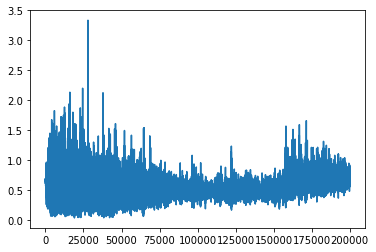

In [51]:
plt.plot(discriminator_losses)

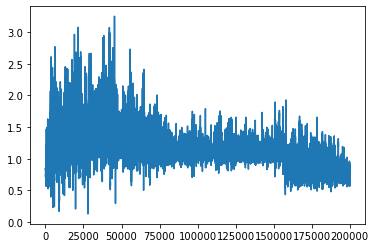

In [52]:
plt.plot(generator_losses)

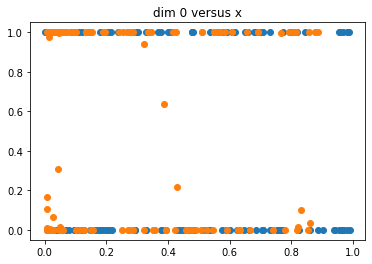

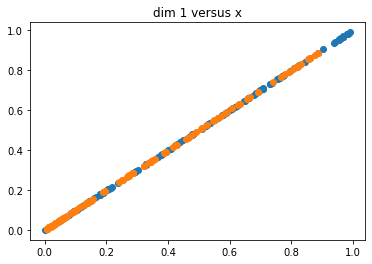

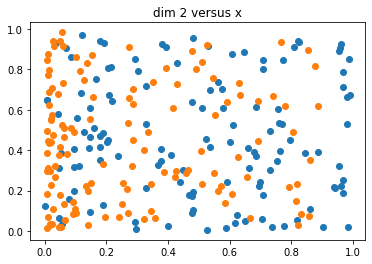

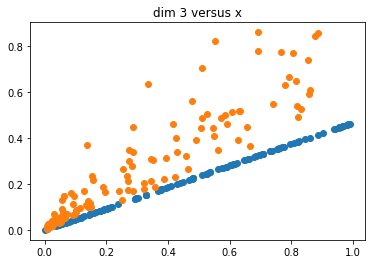

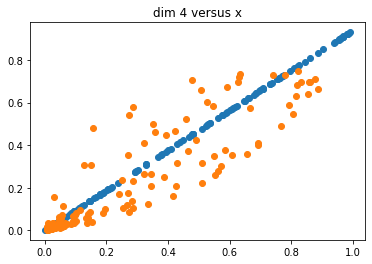

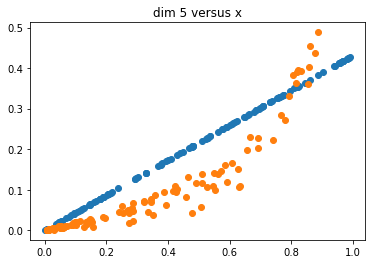

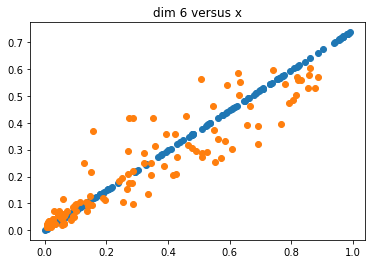

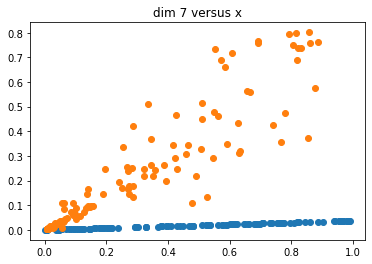

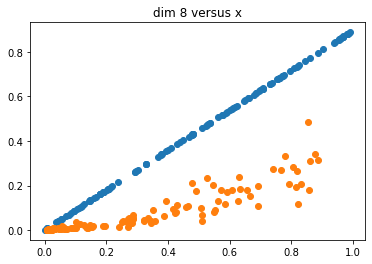

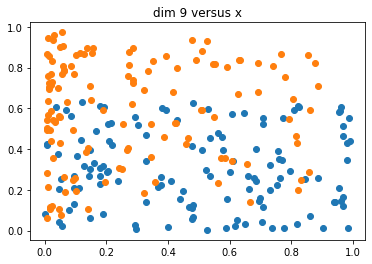

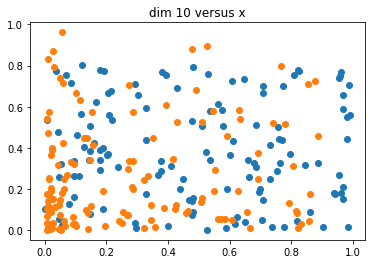

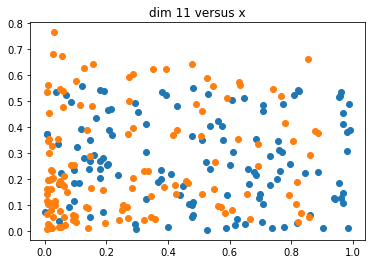

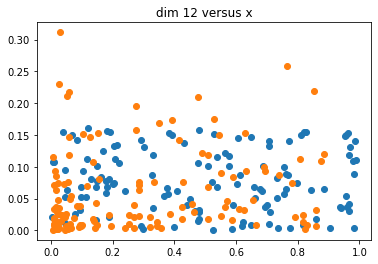

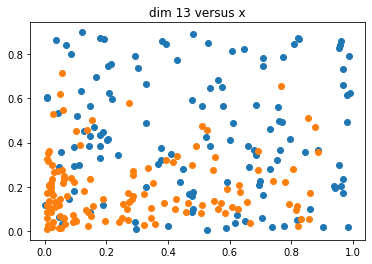

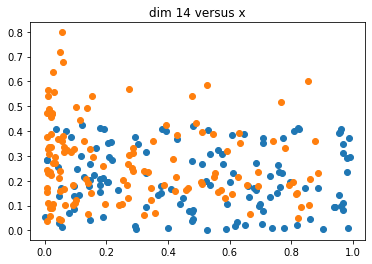

In [53]:
for k in range(n_dim):
    plt.scatter(real_data[:,1].detach().numpy(), real_data[:,k].detach().numpy())
    plt.scatter(fake_data[:,1].detach().numpy(), fake_data[:,k].detach().numpy())
    plt.title(f'dim {k} versus x')
    plt.show()

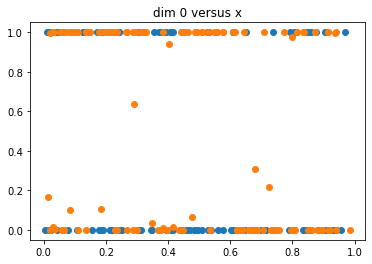

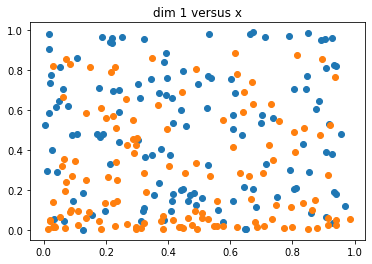

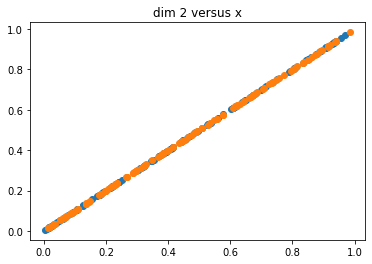

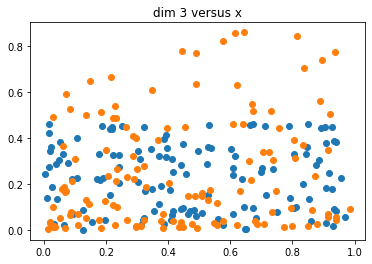

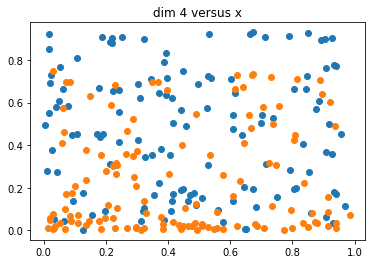

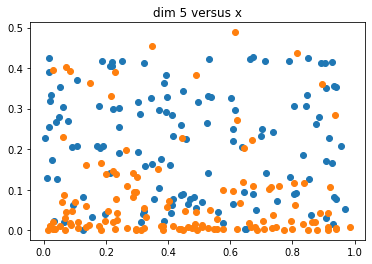

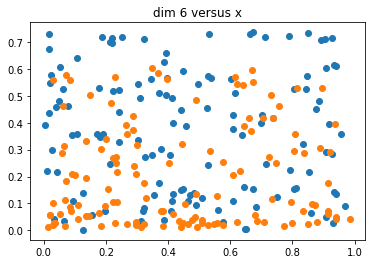

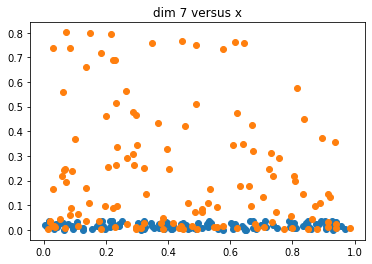

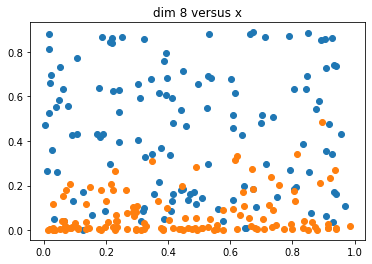

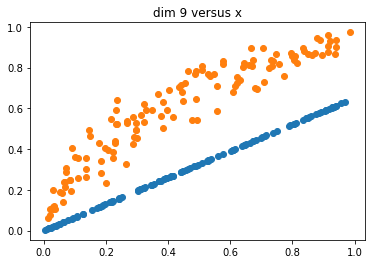

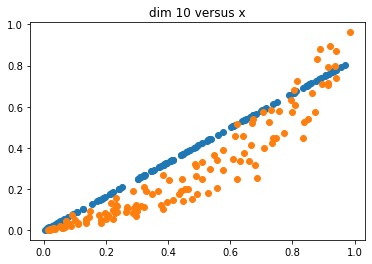

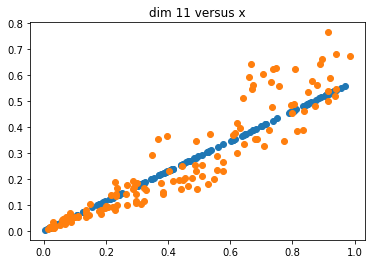

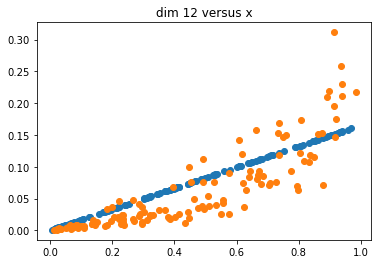

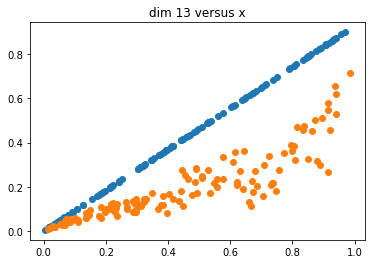

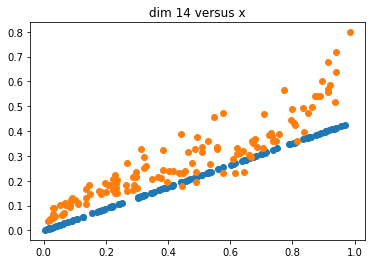

In [54]:
for k in range(n_dim):
    plt.scatter(real_data[:,2].detach().numpy(), real_data[:,k].detach().numpy())
    plt.scatter(fake_data[:,2].detach().numpy(), fake_data[:,k].detach().numpy())
    plt.title(f'dim {k} versus x')
    plt.show()